## Connection between high weight and similar neuron concept

In [ ]:
import os
#virtually move to parent directory
os.chdir("..")

import math
import numpy as np
import torch
from scipy import stats
from matplotlib import pyplot as plt

from sentence_transformers import SentenceTransformer

import clip
import utils
import data_utils
import similarity

## Settings

In [2]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'layer4'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'

batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

with open(concept_set, 'r') as f:
    words = f.read().split('\n')

pil_data = data_utils.get_data(d_probe)

In [4]:
target_model, _ = data_utils.get_target_model(target_name, device)
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                       text_save_name, similarity_fn, device=device)
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

100%|██████████| 2048/2048 [00:14<00:00, 141.76it/s]


torch.Size([2048, 20000])


## Find neurons connected by highest weights

In [5]:
fc_weight = target_model.state_dict()['fc.weight']
fc_bias = target_model.state_dict()['fc.bias']

print(fc_weight.shape)

torch.Size([1000, 2048])


In [6]:
#load mpnet model and clip model
model = SentenceTransformer('all-mpnet-base-v2')
clip_model, _ = clip.load(clip_name, device=device)

In [7]:
def get_cos_similarity_matrix(preds, gt):
    pred_tokens = clip.tokenize(preds).to(device)
    gt_tokens = clip.tokenize(gt).to(device)
    pred_embeds = []
    gt_embeds = []

    #print(preds)
    with torch.no_grad():
        for i in range(math.ceil(len(pred_tokens)/batch_size)):
            pred_embeds.append(clip_model.encode_text(pred_tokens[batch_size*i:batch_size*(i+1)]))
        
        for i in range(math.ceil(len(gt_tokens)/batch_size)):
            gt_embeds.append(clip_model.encode_text(gt_tokens[batch_size*i:batch_size*(i+1)]))

        pred_embeds = torch.cat(pred_embeds, dim=0)
        pred_embeds /= pred_embeds.norm(dim=-1, keepdim=True)
        gt_embeds = torch.cat(gt_embeds, dim=0)
        gt_embeds /= gt_embeds.norm(dim=-1, keepdim=True)

    #l2_norm_pred = torch.norm(pred_embeds-gt_embeds, dim=1)
    print(pred_embeds.shape, gt_embeds.shape)
    cos_sim_clip = gt_embeds@pred_embeds.T

    gt_embeds = model.encode([gt_x for gt_x in gt])
    pred_embeds = model.encode(preds)
    #print(pred_embeds.shape, gt_embeds.shape)
    #l2_norm_pred = np.linalg.norm(pred_embeds-gt_embeds, axis=1)
    cos_sim_mpnet = gt_embeds@pred_embeds.T
    print(cos_sim_clip.shape, cos_sim_mpnet.shape)

    return cos_sim_clip, cos_sim_mpnet

In [8]:
with open('data/imagenet_labels.txt', 'r') as f: 
    cls_id_to_name = (f.read()).split('\n')

preds = torch.argmax(similarities, dim=1)
preds = [words[int(pred)] for pred in preds]

clip_sims, mpnet_sims = get_cos_similarity_matrix(preds, cls_id_to_name)

torch.Size([2048, 512]) torch.Size([1000, 512])
torch.Size([1000, 2048]) (1000, 2048)


## Fig 5a

In [9]:
def plot_neurons(ids_to_check):
    for i, orig_id in enumerate(ids_to_check):

        fig = plt.figure(figsize=(13, 7))
        for i, top_id in enumerate(top_ids[:, orig_id]):
            im, label = pil_data[top_id]
            im = im.resize([250,250])
            fig.add_subplot(1, 5, i+1)
            plt.imshow(im)
            plt.axis('off')

        plt.show()

In [10]:
print(clip_sims.shape, fc_weight.shape, similarities.shape)

torch.Size([1000, 2048]) torch.Size([1000, 2048]) torch.Size([2048, 20000])


Start: layer4 Neuron:24 -  concept:jeans, sim:0.4854
End: Neuron:608 - Gt concept:jean, blue jean, denim
Weight:0.7371 - Similarity to start concept: 0.9038


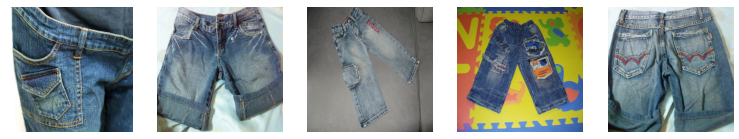

Start: layer4 Neuron:261 -  concept:roofing, sim:0.4803
End: Neuron:858 - Gt concept:tile roof
Weight:0.5942 - Similarity to start concept: 0.8789


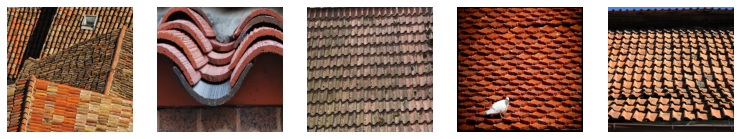

Start: layer4 Neuron:599 -  concept:buses, sim:0.5037
End: Neuron:779 - Gt concept:school bus
Weight:0.5910 - Similarity to start concept: 0.8955


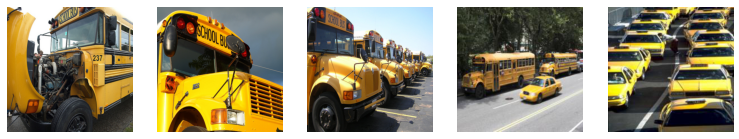

Start: layer4 Neuron:768 -  concept:wicker, sim:0.7356
End: Neuron:588 - Gt concept:hamper
Weight:0.5682 - Similarity to start concept: 0.8003


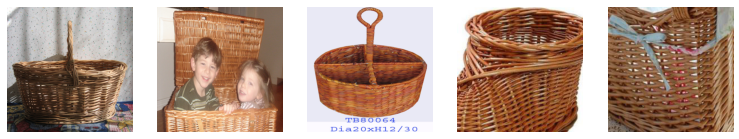

Start: layer4 Neuron:1230 -  concept:puzzle, sim:0.5137
End: Neuron:611 - Gt concept:jigsaw puzzle
Weight:0.5320 - Similarity to start concept: 0.9336


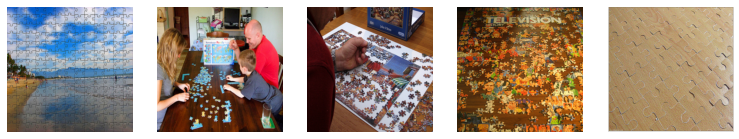

Start: layer4 Neuron:1730 -  concept:televisions, sim:0.4554
End: Neuron:851 - Gt concept:television, television system
Weight:0.5025 - Similarity to start concept: 0.8232


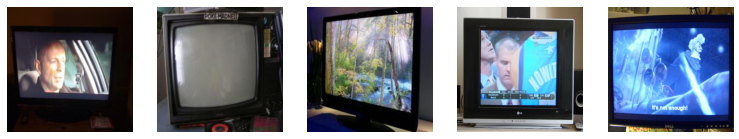

Start: layer4 Neuron:252 -  concept:fence, sim:0.4503
End: Neuron:489 - Gt concept:chainlink fence
Weight:0.5011 - Similarity to start concept: 0.8589


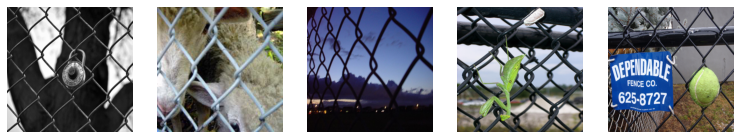

Start: layer4 Neuron:768 -  concept:wicker, sim:0.7356
End: Neuron:790 - Gt concept:shopping basket
Weight:0.4990 - Similarity to start concept: 0.7852


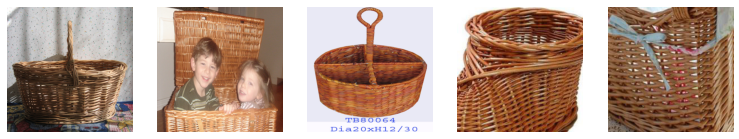

Start: layer4 Neuron:1987 -  concept:crimson, sim:0.2656
End: Neuron:885 - Gt concept:velvet
Weight:0.4904 - Similarity to start concept: 0.7358


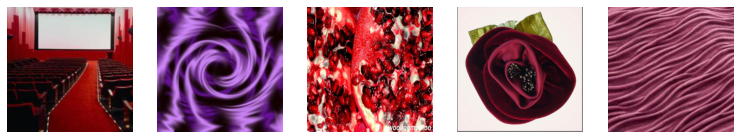

Start: layer4 Neuron:507 -  concept:sunglasses, sim:0.3999
End: Neuron:837 - Gt concept:sunglasses, dark glasses, shades
Weight:0.4896 - Similarity to start concept: 0.9468


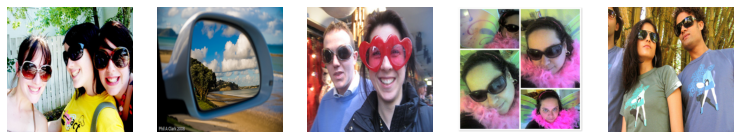

In [11]:
top_weights = torch.max(fc_weight, dim=1)[0]
final_neurons_to_check = torch.topk(top_weights, k=10, largest=True)[1]

for n_id in final_neurons_to_check:
    weight, input_neuron_id = torch.topk(fc_weight[n_id], k=1, largest=True)
    sim, concept_id = torch.topk(similarities[input_neuron_id], k=1, largest=True)
    print('Start: {} Neuron:{} -  concept:{}, sim:{:.4f}'.format(target_layer, input_neuron_id.item(),
                                                                words[int(concept_id)], float(sim))) 
    print("End: Neuron:{} - Gt concept:{}".format(n_id, cls_id_to_name[n_id]))
    print("Weight:{:.4f} - Similarity to start concept: {:.4f}".format(float(weight),
                                            float(clip_sims[n_id, input_neuron_id])))
    plot_neurons(input_neuron_id)
   

## Fig 5b

In [12]:
top_weights, ids = torch.sort(fc_weight.view([-1]), descending=True)
sorted_clip_sims = clip_sims.view([-1])[ids]
sorted_mpnet_sims = torch.tensor(mpnet_sims).view([-1])[ids]
print(top_weights[:10])
print(sorted_clip_sims[:10])
print(sorted_mpnet_sims[:10])

tensor([0.7371, 0.5942, 0.5910, 0.5682, 0.5320, 0.5025, 0.5011, 0.4990, 0.4904,
        0.4896], device='cuda:0')
tensor([0.9038, 0.8789, 0.8955, 0.8003, 0.9336, 0.8232, 0.8589, 0.7852, 0.7358,
        0.9468], device='cuda:0', dtype=torch.float16)
tensor([0.6808, 0.6977, 0.7203, 0.3754, 0.5859, 0.7824, 0.6757, 0.2772, 0.4090,
        0.8149])


20 20
tensor(0.6436)


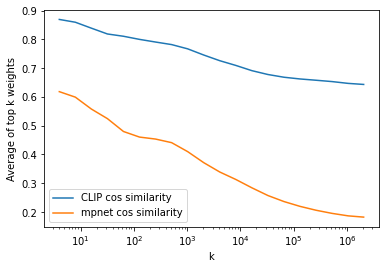

In [13]:
xs = [2**i for i in range(2,21)]
xs.append(len(sorted_clip_sims))
clip_ys = []
mpnet_ys = []
weight_ys = []
for x in xs:
    clip_ys.append(torch.mean(sorted_clip_sims[:x].float().cpu()))
    mpnet_ys.append(torch.mean(sorted_mpnet_sims[:x].float().cpu()))
    weight_ys.append(torch.mean(top_weights[:x].float().cpu()))

percentile_xs = [x/len(sorted_clip_sims) for x in xs]
print(len(clip_ys), len(mpnet_ys))
print(clip_ys[-1])
plt.plot(xs, clip_ys, label='CLIP cos similarity')
plt.plot(xs, mpnet_ys, label='mpnet cos similarity')
#plt.plot(xs, weight_ys, label='average weight')
plt.ylabel('Average of top k weights')
plt.xlabel('k')
plt.legend(loc='lower left')#, bbox_to_anchor=[1.6,1])
plt.xscale('log')

## Correlation coefficient

In [14]:
stats.pearsonr(top_weights[:].cpu(), sorted_mpnet_sims[:].cpu())

(0.11992246733455043, 0.0)

## Other analysis

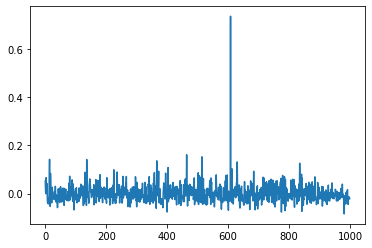

In [15]:
# here we can see there is only one large outgoing weight from layer4 neuron 24
plt.plot(fc_weight[:, 24].cpu())

## More interpretable neurons have higher highest outgoing weight

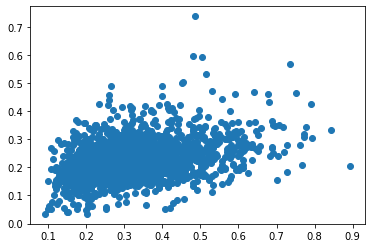

In [16]:
neuron_interpretability = torch.max(similarities, dim=1)[0]
highest_weight = torch.max(fc_weight, dim=0)[0]
#print(neuron_interpretability.shape, highest_weight.shape)
plt.scatter(neuron_interpretability.cpu(), highest_weight.cpu())

In [17]:
stats.pearsonr(neuron_interpretability.cpu(), highest_weight.cpu())

(0.3862917585319876, 7.255987814735164e-74)

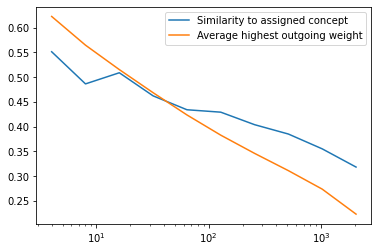

In [18]:
sorted_weight, ids = torch.sort(highest_weight, descending=True)
sorted_interpretability = neuron_interpretability[ids]

xs = [2**i for i in range(2,11)]
xs.append(2048)
interprets = []
max_weights = []
for x in xs:
    interprets.append(torch.mean(sorted_interpretability[:x].float().cpu()))
    max_weights.append(torch.mean(sorted_weight[:x].float().cpu()))

plt.xscale('log')
plt.plot(xs, np.array(interprets), label='Similarity to assigned concept')
plt.plot(xs, max_weights, label='Average highest outgoing weight')
plt.legend()